## Enviroment: 
Open AI gym [CartPole v0](https://github.com/openai/gym/wiki/CartPole-v0)



### Observation

Type: Box(4)

| Num  | Observation          | Min      | Max     |
| ---- | -------------------- | -------- | ------- |
| 0    | Cart Position        | -2.4     | 2.4     |
| 1    | Cart Velocity        | -Inf     | Inf     |
| 2    | Pole Angle           | ~ -41.8° | ~ 41.8° |
| 3    | Pole Velocity At Tip | -Inf     | Inf     |

### Actions

Type: Discrete(2)

| Num  | Action                 |
| ---- | ---------------------- |
| 0    | Push cart to the left  |
| 1    | Push cart to the right |

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

### Reward

Reward is 1 for every step taken, including the termination step

### Starting State

All observations are assigned a uniform random value between ±0.05

### Episode Termination

1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200

### Solved Requirements

Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials


## 1. gym enviroment setup

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CartPole-v0")
env.reset()

array([ 0.01610188, -0.02496384, -0.0061698 ,  0.01667973])

## 2. Q Table setup

In [12]:
LEARNING_RATE = 0.5
DISCOUNT = 0.95
EPISODES = 50000
SHOW_EVERY = 1000
Q_TABLE_LEN = 150

In [13]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [19]:
DISCRETE_OS_SIZE = [Q_TABLE_LEN] * (len(env.observation_space.high))


observation_high = np.array([env.observation_space.high[0],
                    Q_TABLE_LEN*sigmoid(env.observation_space.high[1]),
                    env.observation_space.high[2],
                    Q_TABLE_LEN*sigmoid(env.observation_space.high[3])])

observation_low = np.array([env.observation_space.low[0],
                    Q_TABLE_LEN*sigmoid(env.observation_space.low[1]),
                    env.observation_space.low[2],
                    Q_TABLE_LEN*sigmoid(env.observation_space.low[3])])

discrete_os_win_size = (observation_high - observation_low) / DISCRETE_OS_SIZE

# q_table = np.random.uniform(low=0, high=1,
#                             size=(DISCRETE_OS_SIZE + [env.action_space.n]))

q_table = np.zeros((DISCRETE_OS_SIZE + [env.action_space.n]))

/Users/hongtao/anaconda3/envs/spinningup/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [20]:
q_table.shape

(150, 150, 150, 150, 2)

### Decay epsilon 

In [21]:
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

## 3. Help functions 

In [22]:
def get_discrete_state (state):
    discrete_state = (state - observation_low) // discrete_os_win_size
    return tuple(discrete_state.astype(int))

def take_epilon_greedy_action(state, epsilon):
    discrete_state = get_discrete_state(state)
    if np.random.random() < epsilon:
        action = np.random.randint(0,env.action_space.n)
    else:
        action = np.argmax(q_table[discrete_state])
    return action

## 4. Rewards Recorder setup 

In [23]:
ep_rewards = []
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

## 5. Train the Agent 

In [24]:
for episode in range(EPISODES):
    # initiate reward every episode
    ep_reward = 0
    if episode % SHOW_EVERY == 0:
        print("episode: {}".format(episode))
        render = True
    else:
        render = False

    state = env.reset()
    done = False
    while not done:
        action = take_epilon_greedy_action(state, epsilon)

        next_state, reward, done, _ = env.step(action)

        ep_reward += reward

        # if render:
        #     env.render()

        if not done:

            td_target = reward + DISCOUNT * np.max(q_table[get_discrete_state(next_state)])

            q_table[get_discrete_state(state)][action] += LEARNING_RATE * (td_target - q_table[get_discrete_state(state)][action])



        state = next_state

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    # recoard aggrated rewards on each epsoide
    ep_rewards.append(ep_reward)

    # every SHOW_EVERY calculate average rewords
    if episode % SHOW_EVERY == 0:
        avg_reward = sum(ep_rewards[-SHOW_EVERY:]) / len(ep_rewards[-SHOW_EVERY:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(avg_reward)
        aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
        aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))

episode: 0
episode: 1000
episode: 2000
episode: 3000
episode: 4000
episode: 5000
episode: 6000
episode: 7000
episode: 8000
episode: 9000
episode: 10000
episode: 11000
episode: 12000
episode: 13000
episode: 14000
episode: 15000
episode: 16000
episode: 17000
episode: 18000
episode: 19000
episode: 20000
episode: 21000
episode: 22000
episode: 23000
episode: 24000
episode: 25000
episode: 26000
episode: 27000
episode: 28000
episode: 29000
episode: 30000
episode: 31000
episode: 32000
episode: 33000
episode: 34000
episode: 35000
episode: 36000
episode: 37000
episode: 38000
episode: 39000
episode: 40000
episode: 41000
episode: 42000
episode: 43000
episode: 44000
episode: 45000
episode: 46000
episode: 47000
episode: 48000
episode: 49000


Text(0, 0.5, 'Rewards')

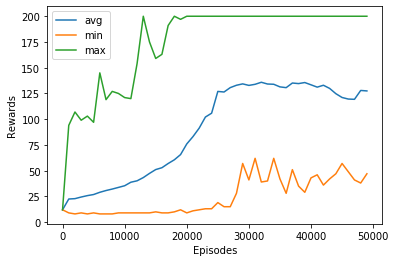

In [26]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

### 6. Rendering Test

In [29]:
done = False
state = env.reset()
while not done:
    action = np.argmax(q_table[get_discrete_state(state)])
    next_state, _, done, _ = env.step(action)
    state = next_state
    env.render()

env.close()